In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
import pickle as pkl
from torch.utils.data import DataLoader, Dataset
from torch import nn, Tensor, optim
import math
import random
import datetime

In [2]:
# data = pd.read_csv('./HIGGS.csv', header=None)

In [3]:
# X = data.iloc[:,1:]
# y = data.iloc[:,0]
# X = X.to_numpy(dtype=float) #Convert pandas dataframe to numpy array (optional)
# y = y.to_numpy(dtype=int)   #Convert pandas dataframe to numpy array (optional)
# np.save('X.npy', X)
# np.save('y.npy', y)

In [4]:
X = np.load('X.npy')
y = np.load('y.npy')

In [5]:
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

In [6]:
X = np.delete(X, obj=np.s_[X.shape[1]-8:X.shape[1]], axis=-1)
X = np.delete(X, obj=np.s_[X.shape[1]-4:X.shape[1]-3], axis=-1)
X = np.delete(X, obj=np.s_[X.shape[1]-7:X.shape[1]-6], axis=-1)
X = np.delete(X, obj=np.s_[X.shape[1]-10:X.shape[1]-9], axis=-1)
X = np.insert(X, obj=np.s_[4:5], values=0, axis=-1)

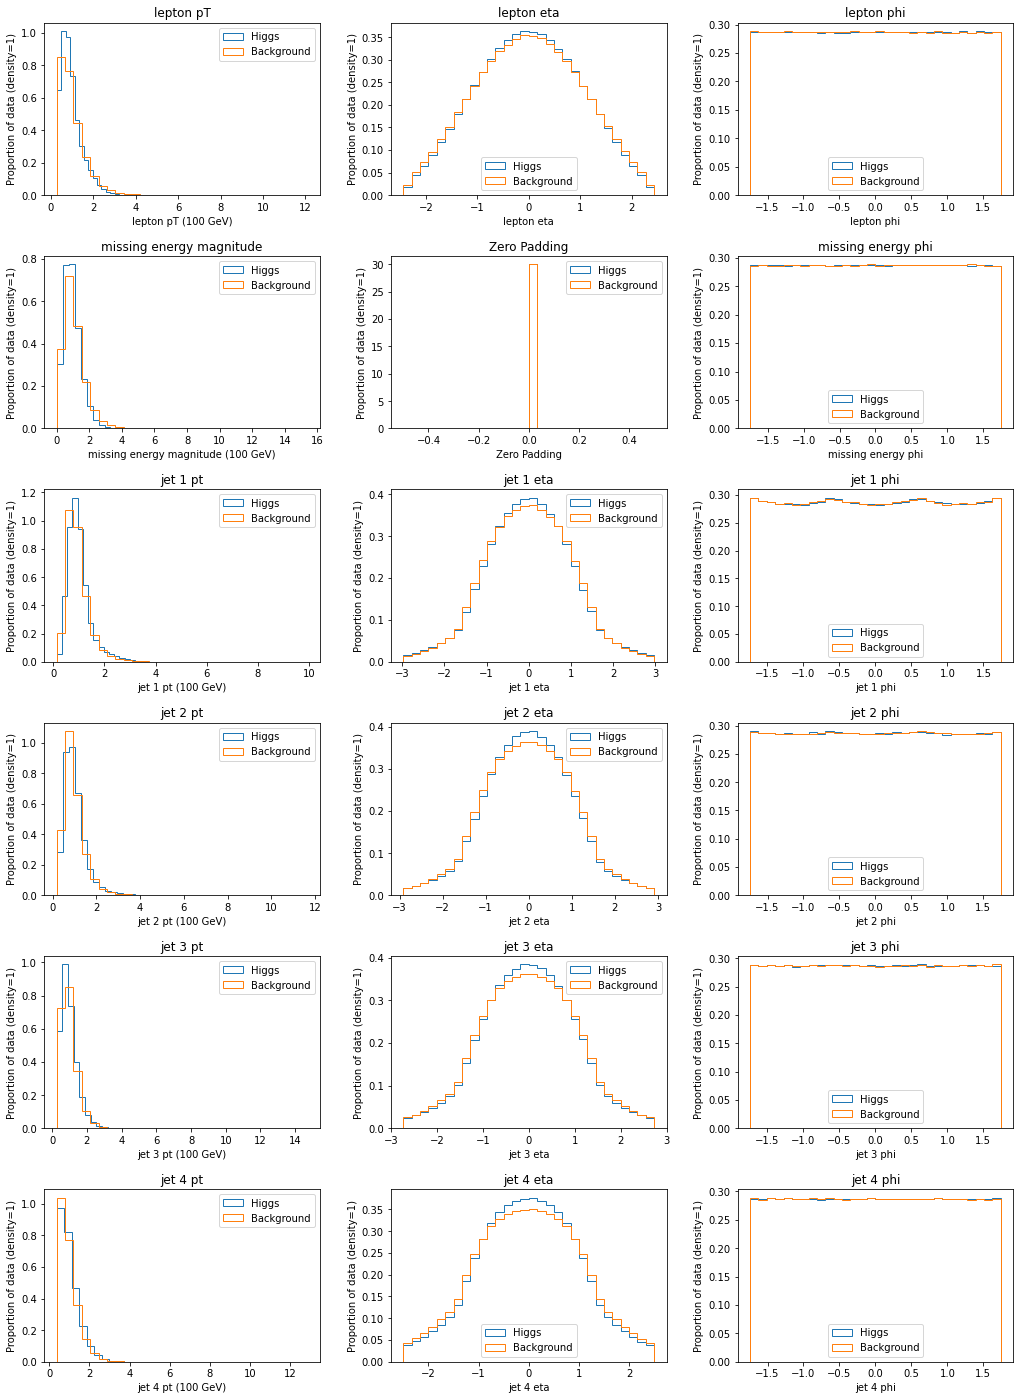

In [7]:
names = ["lepton pT", "lepton eta", "lepton phi", 
         "missing energy magnitude", "Zero Padding", "missing energy phi",
         "jet 1 pt", "jet 1 eta", "jet 1 phi",
         "jet 2 pt", "jet 2 eta", "jet 2 phi", 
         "jet 3 pt", "jet 3 eta", "jet 3 phi", 
         "jet 4 pt", "jet 4 eta", "jet 4 phi"]

fig, axes = plt.subplots(6,3, figsize=(15,20))
fig.tight_layout(pad=4)

X_higgs = X[y==1]
X_nohiggs = X[y==0]
y_higgs = y[y==1]
y_nohiggs = y[y==0]

for i in range(len(axes)):
    for j in range(len(axes[0])):
        axes[i,j].hist(X_higgs[:,i*3+j], histtype='step', density=1, bins=30, label='Higgs')
        axes[i,j].hist(X_nohiggs[:,i*3+j], histtype='step', density=1, bins=30, label='Background')
        axes[i,j].set_title(names[i*3+j])
        if j == 0:
            axes[i,j].set_xlabel(names[i*3+j] + ' (100 GeV)')
        else:
            axes[i,j].set_xlabel(names[i*3+j])
        axes[i,j].legend()
        axes[i,j].set_ylabel("Proportion of data (density=1)")
plt.show()

In [8]:
X_train, X_val1, y_train, y_val1 = train_test_split(X_higgs, y_higgs, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val1, y_val1, test_size=0.5, random_state=42)

In [9]:
x_scaler = StandardScaler()
# y_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
X_val = x_scaler.transform(X_val)
X_test = x_scaler.transform(X_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [10]:
class KinematicMask(nn.Module):
    def __init__(self, mask_count):
        super(KinematicMask, self).__init__()
        self.mask_count = mask_count

    def forward(self, x):
        assert x.dim() == 3, "Input tensor must be 3-dimensional (batch_size, seq_len, dim_in)"
        batch_size, seq_len, _ = x.size()
        assert self.mask_count <= seq_len, "Mask count must be less than or equal to the sequence length"

        # Generate a mask tensor with the same shape as the input tensor
        mask = torch.ones(batch_size, seq_len, 1, device=x.device)

        # Generate a set of unique random indices to mask for each sample in the batch
        for b in range(batch_size):
            mask_indices = set()
            while len(mask_indices) < self.mask_count:
                mask_indices.add(random.randint(0, seq_len - 1))

            # Zero out the elements at the selected indices
            for idx in mask_indices:
                mask[b, idx] = 0

        return x * mask

In [11]:
class ParticleMask(nn.Module):
    def __init__(self, group_size=3):
        super(ParticleMask, self).__init__()
        self.group_size = group_size

    def forward(self, x):
        assert x.dim() == 3, "Input tensor must be 3-dimensional (batch_size, seq_len, dim_in)"
        batch_size, seq_len, _ = x.size()
        assert seq_len % self.group_size == 0, "Sequence length must be divisible by group_size"

        # Calculate the number of groups
        num_groups = seq_len // self.group_size

        # Generate a mask tensor with the same shape as the input tensor
        mask = torch.ones(batch_size, seq_len, 1, device=x.device)

        # Generate a random starting index for each sample in the batch
        for b in range(batch_size):
            start_idx = random.randint(0, num_groups - 1) * self.group_size

            # Zero out the elements at the selected indices
            for idx in range(start_idx, start_idx + self.group_size):
                mask[b, idx] = 0

        return x * mask

In [12]:
class SpecificParticleMask(nn.Module):
    def __init__(self, group_size=3, particle=0):
        super(SpecificParticleMask, self).__init__()
        self.group_size = group_size
        self.particle = particle

    def forward(self, x):
        assert x.dim() == 3, "Input tensor must be 3-dimensional (batch_size, seq_len, dim_in)"
        batch_size, seq_len, _ = x.size()
        assert seq_len % self.group_size == 0, "Sequence length must be divisible by group_size"

        # Calculate the number of groups
        num_groups = seq_len // self.group_size

        # Generate a mask tensor with the same shape as the input tensor
        mask = torch.ones(batch_size, seq_len, 1, device=x.device)

        # Generate a random starting index for each sample in the batch
        for b in range(batch_size):
            start_idx = self.particle * self.group_size

            # Zero out the elements at the selected indices
            for idx in range(start_idx, start_idx + self.group_size):
                mask[b, idx] = 0

        return x * mask

In [13]:
# Linear Embedding
class LinearEmbedding(nn.Module):
    def __init__(self, d_model, linear: bool = False):
        super(LinearEmbedding, self).__init__()
        self.embedding_layer = nn.Linear(1, d_model)
        self.relu = nn.ReLU()
        self.linear = linear
        
    def forward(self, x: Tensor):
        if self.linear:
            return self.embedding_layer(x)
        else:
            return self.relu(self.embedding_layer(x))

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=28):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(1, max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))

        self.encoding[:, :, 0::2] = torch.sin(position * div_term)
        self.encoding[:, :, 1::2] = torch.cos(position * div_term)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        return x + self.encoding[:, :seq_len, :]

In [14]:
# Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, d_ff, max_seq_len, dropout, device):
        super(TransformerAutoencoder, self).__init__()
        self.trans = nn.Transformer(d_model=d_model, nhead=num_heads, 
                                    num_encoder_layers=num_layers, num_decoder_layers=num_layers,
                                    dim_feedforward=d_ff, dropout=dropout, 
                                    activation='relu', custom_encoder=None, 
                                    custom_decoder=None, layer_norm_eps=1e-05, 
                                    batch_first=True, norm_first=False, 
                                    device=device, dtype=None)
        self.embedding = LinearEmbedding(d_model)
        self.pos_enc = PositionalEncoding(d_model, max_seq_len)
        self.dense = nn.Linear(d_model, 1)
        
    def forward(self, src, tgt):
        src = self.embedding(src)
        tgt = self.embedding(tgt)
        src = self.pos_enc(src)
        tgt = self.pos_enc(tgt)
        return self.dense(self.trans(src, tgt))

In [15]:
# Validation loop
def validate(val_loader, model, criterion, mask, epoch, num_epochs, val_loss_min):
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_losses = []
    with torch.no_grad():  # Disable gradient calculations
        for val_batch in val_loader:
            # Move the data to the device
            val_inputs = val_batch.to(device)
            if mask is not None:
                if mask == 0:
                    mask_layer = ParticleMask(3)
                else:
                    mask_layer = KinematicMask(mask)
                # Mask input data
                masked_val_inputs = mask_layer(val_inputs)
                masked_val_inputs = masked_val_inputs.detach()

            # Forward pass
            val_outputs = model(masked_val_inputs, masked_val_inputs)

            # Calculate the loss
            val_loss = criterion(val_outputs, val_inputs)
            val_losses.append(val_loss.item())

    val_loss_mean = sum(val_losses) / len(val_losses)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss_mean:.4f}")
    if val_loss_mean < val_loss_min:
        val_loss_min = val_loss_mean
        torch.save(model.state_dict(), './TAE_best_' + model_name)
    return val_loss_min
    
# Training loop
def train(train_loader, val_loader, model, optimizer, criterion, mask=None, num_epochs:int = 50, val_loss_min=999):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, batch in enumerate(train_loader):
            # Move the data to the device
            inputs = batch.to(device)
            if mask is not None:
                if mask == 0:
                    mask_layer = ParticleMask(3)
                else:
                    mask_layer = KinematicMask(mask)
                # Mask input data
                masked_inputs = mask_layer(inputs)
                masked_inputs = masked_inputs.detach()

            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(masked_inputs, masked_inputs)

            # Calculate the loss
            loss = criterion(outputs, inputs)

            # Backward pass
            loss.backward()

            # Update the parameters
            optimizer.step()
            
            # Update running loss
            running_loss += loss.item()
            
            # Print running loss every 1000 batches
            if (batch_idx + 1) % 500 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss / 500:.4f}")
                running_loss = 0.0
                
        val_loss_min = validate(val_loader, model, criterion, mask, epoch, num_epochs, val_loss_min)
    return val_loss_min

In [30]:
def make_hist2d(group_num, group_size, step, inputs, outputs):
    lower = np.min((outputs[:,group_num*group_size+step], inputs[:,group_num*group_size+step]))
    upper = np.max((outputs[:,group_num*group_size+step], inputs[:,group_num*group_size+step]))
    varname = names[group_num*group_size+step]
    heatmap, xedges, yedges = np.histogram2d(inputs[:,group_num*group_size+step],
                                             outputs[:,group_num*group_size+step], 
                                             bins=30, 
                                             range=[[lower, upper], [lower, upper]])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    #Plot heatmap
    plt.imshow(heatmap.T, 
               extent=extent, 
               origin='lower')
    plt.plot([lower, upper], 
             [lower, upper], 
             color='blue')
    fig = plt.gcf()
    plt.set_cmap('gist_heat_r')
    plt.xlabel('%s True' % varname)
    plt.ylabel('%s Pred' % varname)
    plt.title('Frequency Heatmap')
    plt.xlim(lower, upper)
    plt.ylim(lower, upper)
    plt.colorbar()
    plt.show()

In [17]:
def test(test_loader, model, criterion, mask, scaler):
    model.eval()
    X_test_arr = scaler.inverse_transform(X_test[:,:,0])
    for i in range(6):
        losses=[]
        outputs_arr = np.zeros((np.shape(X_test)[0], np.shape(X_test)[1]))
        for batch_idx, batch in enumerate(test_loader):
            # Move the data to the device
            inputs = batch.to(device)
            if mask is not None:
                    if mask == 0:
                        mask_layer = SpecificParticleMask(3, i)
                    else:
                        mask_layer = KinematicMask(mask)
                    # Mask input data
                    masked_inputs = mask_layer(inputs)
                    masked_inputs = masked_inputs.detach()

            # Forward pass
            outputs = model(masked_inputs, masked_inputs)
            outputs_arr[batch_size*batch_idx:batch_size*(batch_idx + 1),:] = outputs.numpy(force=True)[:,:,0]

            # Calculate the loss
            loss = criterion(outputs, inputs)
            losses.append(loss.item())
            loss_mean = sum(losses) / len(losses)
        print('Test MSE: ', loss_mean)
        
        # Scale back to original scale
        outputs_arr = scaler.inverse_transform(outputs_arr)
        
        # Generate scatter plots
        make_hist2d(i, 3, 0, X_test_arr, outputs_arr)
        make_hist2d(i, 3, 1, X_test_arr, outputs_arr)
        make_hist2d(i, 3, 2, X_test_arr, outputs_arr)

In [18]:
# Custom Dataset class
class MyDataset(Dataset):
    def __init__(self, data, dtype: str = 'numpy'):
        super(MyDataset, self).__init__()
        if dtype == 'numpy':
            self.data = torch.from_numpy(data)
    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return len(self.data)

In [19]:
def get_d_model(array):    
    for item in range(0, 256, 4):
        if item > int((array.shape[0]*array.shape[1])**.25):
            return item

In [20]:
d_model = get_d_model(X)
num_heads = 4
num_layers = 2
d_ff = d_model * 4
dropout = 0.
batch_size = 256
num_epochs = 2
init_lr = 0.001
max_seq_len = X_train.shape[1]
mask = 0

In [21]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# Build the autoencoder model
model = TransformerAutoencoder(d_model, num_heads, num_layers, d_ff, max_seq_len, dropout, device)

In [23]:
model.to(device)

# Set the optimizer and loss function
criterion = nn.MSELoss()  # Use nn.CrossEntropyLoss() for categorical input

In [24]:
# Instantiate the dataset and DataLoader
train_data = MyDataset(X_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = MyDataset(X_val)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_data = MyDataset(X_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [25]:
# Execute the training loop with a learning rate decay
val_loss_min = 999
model_name = "{0}L_{1}H_{2}D_{3}B_{4}DR_{5}".format(num_layers, 
                                                    num_heads,
                                                    d_model,
                                                    batch_size,
                                                    round(dropout, 3),
                                                    datetime.datetime.now().strftime('%b%d_%H-%M-%S'))
for i in range(3):
    lr = init_lr / 10**i
    optimizer = optim.Adam(model.parameters(), lr=lr)
    val_loss_min = train(train_loader, val_loader, model, optimizer, criterion, 0, num_epochs, val_loss_min)

Test MSE:  0.10888411461836


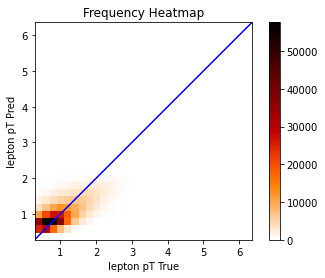

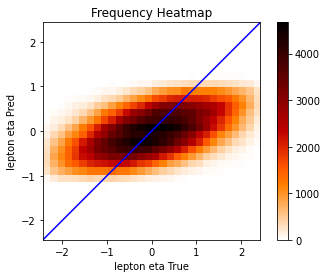

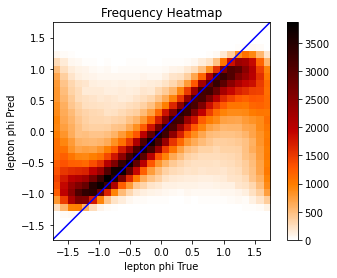

Test MSE:  0.07408986792386991


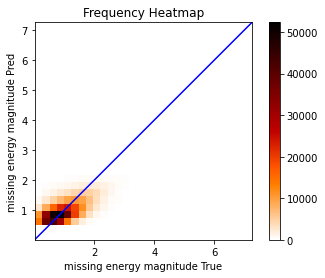

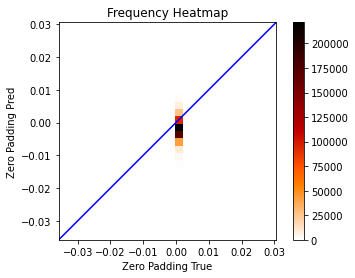

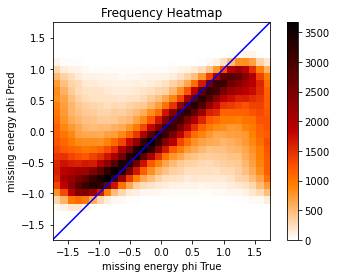

Test MSE:  0.0843605153766298


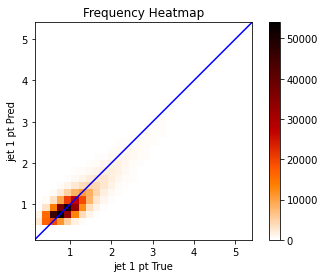

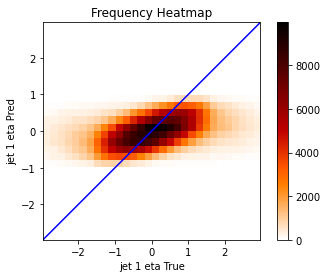

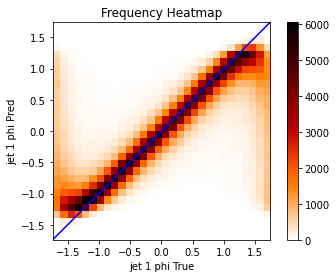

Test MSE:  0.09488377913414019


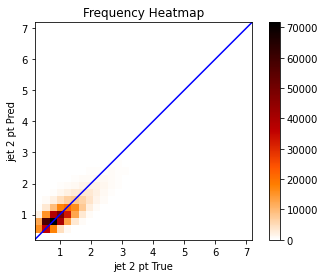

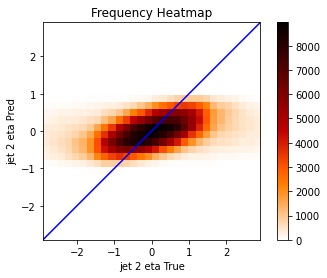

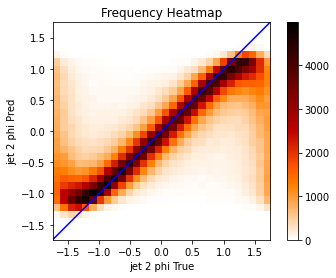

Test MSE:  0.11223203980930549


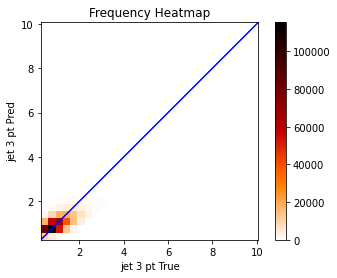

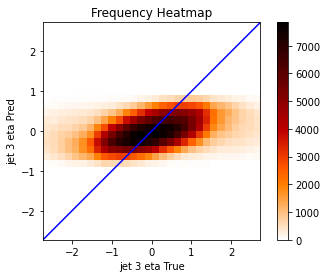

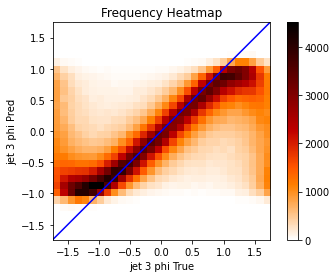

Test MSE:  0.12708283450595112


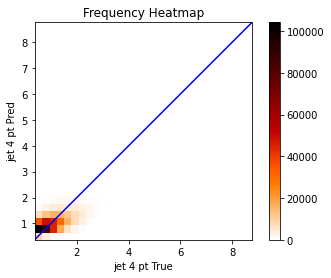

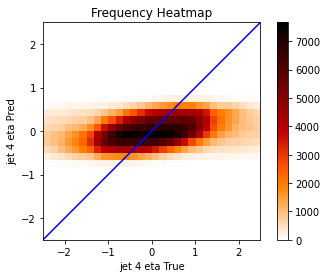

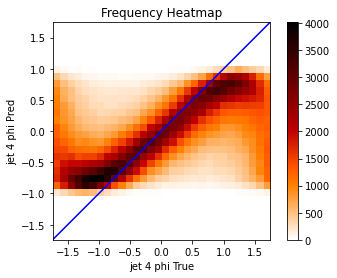

In [31]:
model = TransformerAutoencoder(d_model, num_heads, num_layers, d_ff, max_seq_len, dropout, device)
model_name = '2L_4H_120D_256B_0.0DR_Apr24_18-40-51'
model.load_state_dict(torch.load('./TAE_best_' + model_name))
test(test_loader, model, criterion, mask, x_scaler)